# Setup, imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/honours
%ls

/content/drive/MyDrive/honours
all/    feature_extraction.py  nonsaturated/      prep_functions.py  saturated/
dried/  model_creation.py      plot_functions.py  __pycache__/       sheets/


In [3]:
from prep_functions import create_images_list, extract_gh_values,extract_lp_values, circle_cut_out, scale_fit_transform
from plot_functions import plot_metrics,lin_regression,plot_predictions,plot_all_validation

In [4]:
from feature_extraction import get_distribution,get_image_contours,get_glcmprops,get_shape_features,get_lbp

In [5]:
import pandas as pd
import numpy as np
import cv2
from google.colab.patches import cv2_imshow #colab bug with imshow

# Data preparation

In [6]:
#loading two datasets into respective dataframes
gh_df = pd.read_csv('/content/drive/MyDrive/honours/sheets/GrievesHouse.csv')
lp_df = pd.read_csv('/content/drive/MyDrive/honours/sheets/LowerPilmore.csv')

gh_df.head()

,Sample,Stable aggregates (%)
0,1,65.88
1,2,23.90
2,2,31.86
3,3,89.14
4,4,68.71


In [7]:
# creating lists of images(scaled down) and respective label
gh_path = "/content/drive/MyDrive/honours/all/GrievesHouse/*.*"
lp_path = "/content/drive/MyDrive/honours/all/LowerPilmore/*.*"

gh_images,gh_labels = create_images_list(gh_path,(665,665),True)
lp_images,lp_labels = create_images_list(lp_path,(665,665),True)


In [8]:
# CSV file naming differs from file naming - cleaning up:
gh_values = extract_gh_values(gh_labels,gh_df)
lp_values = extract_lp_values(lp_labels,lp_df)

all_values = gh_values + lp_values
all_values = np.array(all_values).reshape(-1, 1)

In [9]:
# scaler = StandardScaler()
# #scaler expectis a 2d array
# st_values = scaler.fit_transform(all_values)

In [10]:
# from skimage.feature import graycomatrix,graycoprops
# from skimage.morphology import disk
# from skimage.filters import rank

# from google.colab.patches import cv2_imshow #colab bug with imshow


In [11]:
all_images = gh_images + lp_images

feature_vectors = []

for curr_img in all_images:

  curr_contours,curr_perimeters,curr_areas = get_image_contours(curr_img)
  curr_aspects,curr_extents,curr_solidities,curr_diameters = get_shape_features(curr_contours)

  lbp_dist = get_lbp(curr_img,curr_contours)

  perimeter_dist = get_distribution(curr_perimeters,20)
  area_dist = get_distribution(curr_areas,20)
  aspect_dist = get_distribution(curr_aspects,20)
  extent_dist = get_distribution(curr_extents,20)
  solidity_dist = get_distribution(curr_solidities,20)

  vec = lbp_dist.tolist() + perimeter_dist.tolist() + area_dist.tolist() + aspect_dist.tolist() + extent_dist.tolist() + \
    solidity_dist.tolist()

  angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]
  for i in range(4):
    for angle in angles:
      contrast,dissimiliarity,homogeneity,energy,correlation = get_glcmprops(curr_img,curr_contours,i,angle)

      vec += contrast.flatten().tolist() + dissimiliarity.flatten().tolist() + \
      homogeneity.flatten().tolist() + energy.flatten().tolist() + correlation.flatten().tolist()

  feature_vectors.append(vec)


In [12]:
X = feature_vectors
y = all_values

In [13]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

In [14]:
kf = KFold(n_splits=5,shuffle=True,random_state=42)

In [15]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

# XGBRegressor

## Hyperparameter tuning

In [16]:
max_depth = [1,2]
n_estimators = [100,200,300]
learning_rate = [0.01,0.02,0.04]

In [17]:
rmse_d = {}
for md in max_depth:
  for e in n_estimators:
    for lr in learning_rate:
      all_rmses = []
      for i,(train_idx,test_idx) in enumerate(kf.split(X)):
        X_train = np.take(X, train_idx, axis=0)
        y_train = np.take(y, train_idx, axis=0)

        X_val = np.take(X, test_idx, axis=0)
        y_val = np.take(y, test_idx, axis=0)

        X_train,X_val = scale_fit_transform(X_train,X_val)
        y_train,y_val = scale_fit_transform(y_train,y_val)

        xgb_m = XGBRegressor(n_estimators=e, max_depth=md, learning_rate=lr)
        xgb_m.fit(X_train,y_train)
        preds = xgb_m.predict(X_val)
        rmse = mean_squared_error(y_val,preds,squared=False)
        all_rmses.append(rmse)
      rmse_d[(md,e,lr)] = np.average(all_rmses)
      print(md,e,lr,':',rmse_d[(md,e,lr)])



1 100 0.01 : 0.9872355355710407
1 100 0.02 : 0.9860797613519902
1 100 0.04 : 0.9916621319447023
1 200 0.01 : 0.9857954247056785
1 200 0.02 : 0.991464773451604
1 200 0.04 : 1.0045859573639855
1 300 0.01 : 0.9873555239621096
1 300 0.02 : 0.9987283530525592
1 300 0.04 : 1.0167787751127455
2 100 0.01 : 0.9902168663187261
2 100 0.02 : 0.9919661723439711
2 100 0.04 : 0.9997093704399933
2 200 0.01 : 0.9923676339642838
2 200 0.02 : 0.998962835844415
2 200 0.04 : 1.0117370114204454
2 300 0.01 : 0.9953180287166022
2 300 0.02 : 1.0091635299315218
2 300 0.04 : 1.0238355804558616


In [18]:
dict(sorted(rmse_d.items(), key=lambda item: item[1]))

{(1, 200, 0.01): 0.9857954247056785,
 (1, 100, 0.02): 0.9860797613519902,
 (1, 100, 0.01): 0.9872355355710407,
 (1, 300, 0.01): 0.9873555239621096,
 (2, 100, 0.01): 0.9902168663187261,
 (1, 200, 0.02): 0.991464773451604,
 (1, 100, 0.04): 0.9916621319447023,
 (2, 100, 0.02): 0.9919661723439711,
 (2, 200, 0.01): 0.9923676339642838,
 (2, 300, 0.01): 0.9953180287166022,
 (1, 300, 0.02): 0.9987283530525592,
 (2, 200, 0.02): 0.998962835844415,
 (2, 100, 0.04): 0.9997093704399933,
 (1, 200, 0.04): 1.0045859573639855,
 (2, 300, 0.02): 1.0091635299315218,
 (2, 200, 0.04): 1.0117370114204454,
 (1, 300, 0.04): 1.0167787751127455,
 (2, 300, 0.04): 1.0238355804558616}

## Best/worst models

------------------------------------------------------------------
------------------------------Fold 0------------------------------
------------------------------------------------------------------


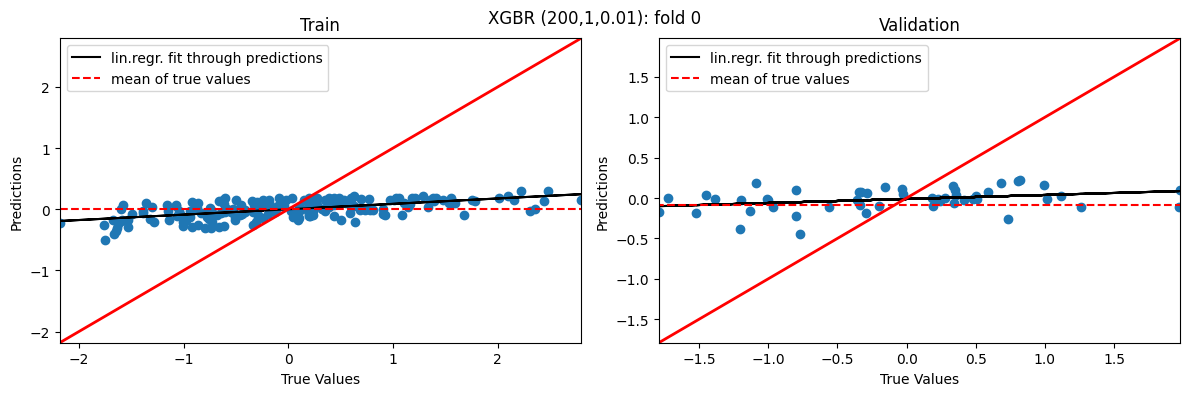

Train RMSE: 0.9194776931444271, MAE: 0.7392298856762828
Validation RMSE: 0.8660652867551816, MAE: 0.7037925747236506
------------------------------------------------------------------
------------------------------Fold 1------------------------------
------------------------------------------------------------------


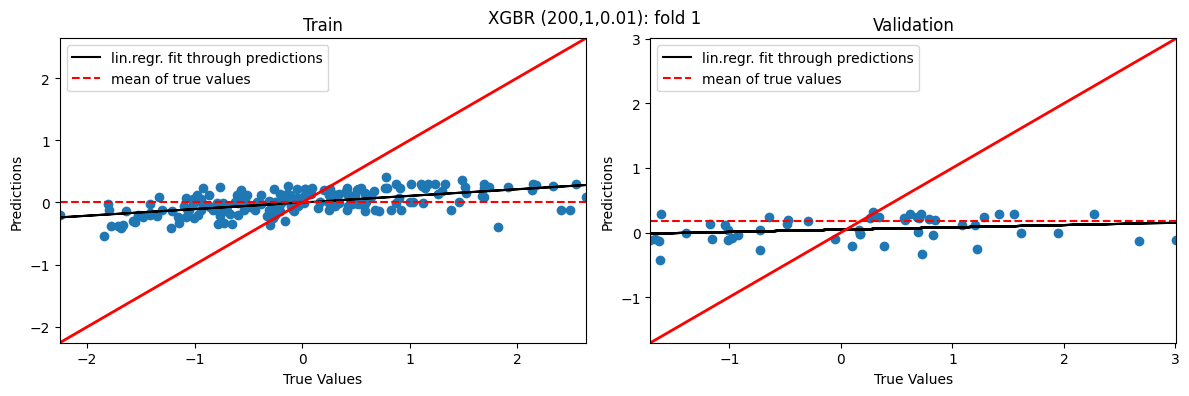

Train RMSE: 0.9060146991357724, MAE: 0.717253403576859
Validation RMSE: 1.1435235263041508, MAE: 0.9319074003422909
------------------------------------------------------------------
------------------------------Fold 2------------------------------
------------------------------------------------------------------


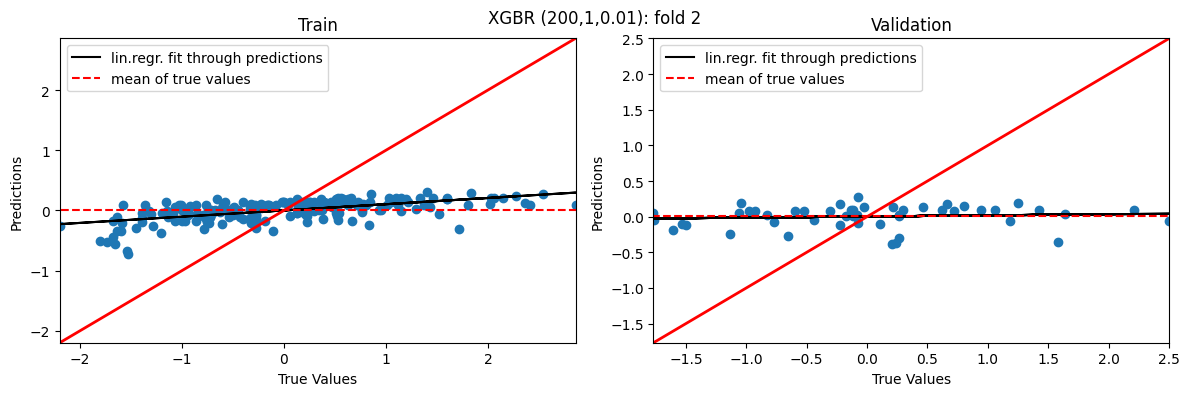

Train RMSE: 0.9073509883687737, MAE: 0.7351697582521218
Validation RMSE: 0.9806703300054032, MAE: 0.7766913773060394
------------------------------------------------------------------
------------------------------Fold 3------------------------------
------------------------------------------------------------------


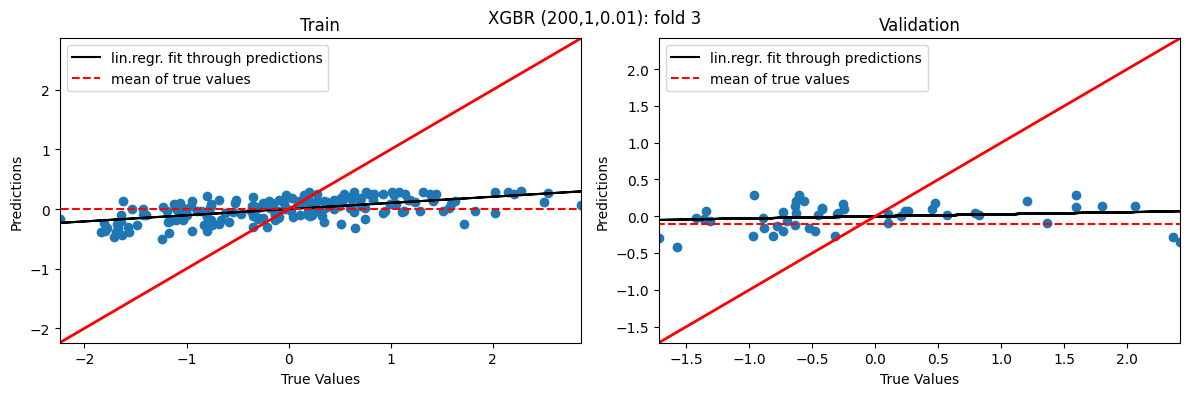

Train RMSE: 0.9080936636883847, MAE: 0.7217111450583852
Validation RMSE: 1.0195026267115452, MAE: 0.8289004635491547
------------------------------------------------------------------
------------------------------Fold 4------------------------------
------------------------------------------------------------------


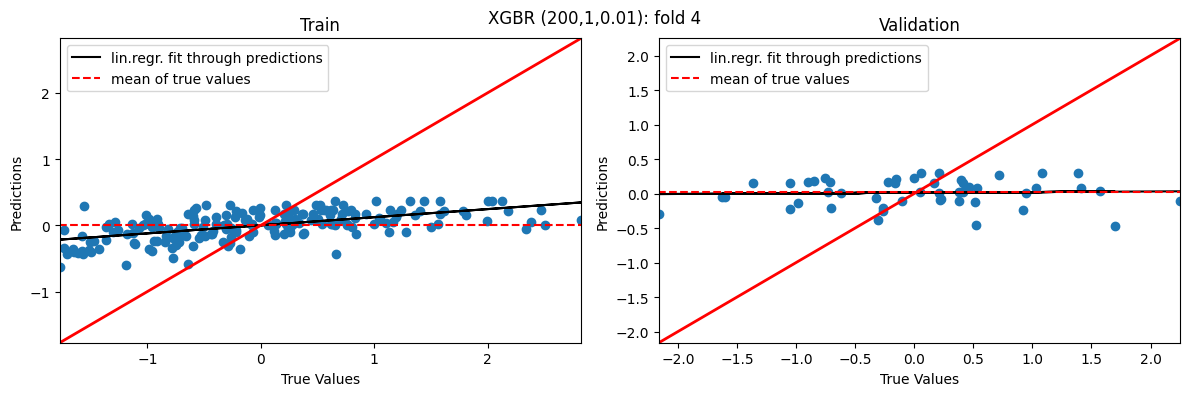

Train RMSE: 0.894256322443157, MAE: 0.7145234847819641
Validation RMSE: 0.9192153537521122, MAE: 0.7152794537941701


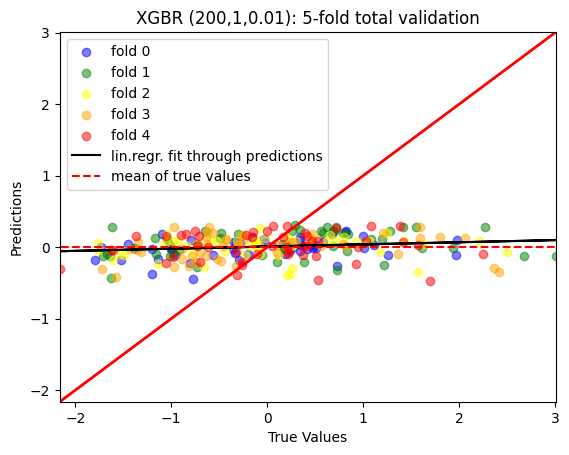

In [21]:
all_val_preds = []
all_val_true = []
for i,(train_idx,test_idx) in enumerate(kf.split(X)):
  print('-'*66)
  print('-'*30+f'Fold {i}'+'-'*30)
  print('-'*66)

  X_train = np.take(X, train_idx, axis=0)
  y_train = np.take(y, train_idx, axis=0)

  X_val = np.take(X, test_idx, axis=0)
  y_val = np.take(y, test_idx, axis=0)

  X_train,X_val = scale_fit_transform(X_train,X_val)
  y_train,y_val = scale_fit_transform(y_train,y_val)

  xgb_model = XGBRegressor(n_estimators=200, max_depth=1, learning_rate=0.01)
  xgb_model.fit(X_train,y_train)
  preds = xgb_model.predict(X_val)
  preds_train = xgb_model.predict(X_train)
  plot_predictions(y_val,preds,y_train,preds_train,f'XGBR (200,1,0.01): fold {i}')
  print(f'Train RMSE: {mean_squared_error(y_train,preds_train,squared=False)}, MAE: {mean_absolute_error(y_train,preds_train)}')
  print(f'Validation RMSE: {mean_squared_error(y_val,preds,squared=False)}, MAE: {mean_absolute_error(y_val,preds)}')

  all_val_preds.append(preds)
  all_val_true.append(y_val)

plot_all_validation(all_val_true,all_val_preds,'XGBR (200,1,0.01): 5-fold total validation')


In [22]:
print('Total validation RMSE:', mean_squared_error(np.concatenate(all_val_true).ravel(),np.concatenate(all_val_preds).ravel(),squared=False))
print('Total validation MAE:', mean_absolute_error(np.concatenate(all_val_true).ravel(),np.concatenate(all_val_preds).ravel()))

Total validation RMSE: 0.9905270720364939
Total validation MAE: 0.7915291181826555


------------------------------------------------------------------
------------------------------Fold 0------------------------------
------------------------------------------------------------------


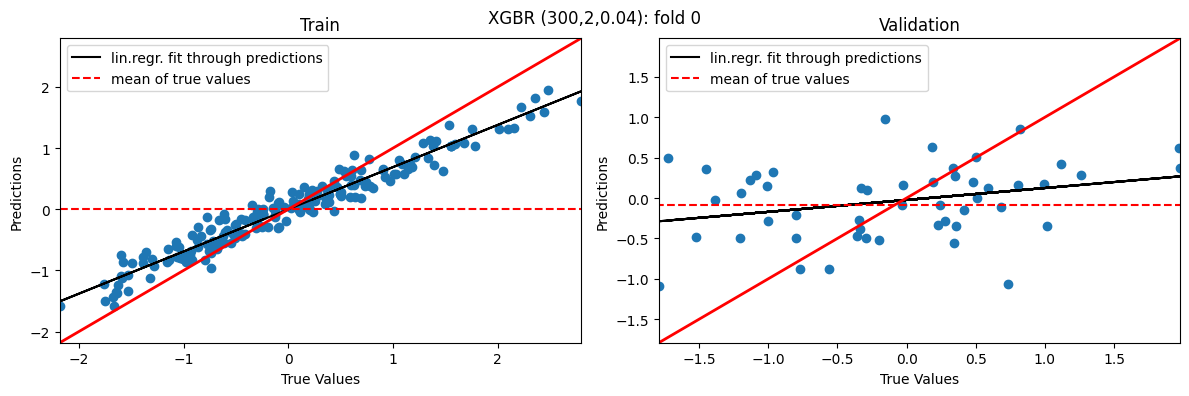

Train RMSE: 0.3523776477018946, MAE: 0.2830093423886319
Validation RMSE: 0.884545256671362, MAE: 0.6958929645676506
------------------------------------------------------------------
------------------------------Fold 1------------------------------
------------------------------------------------------------------


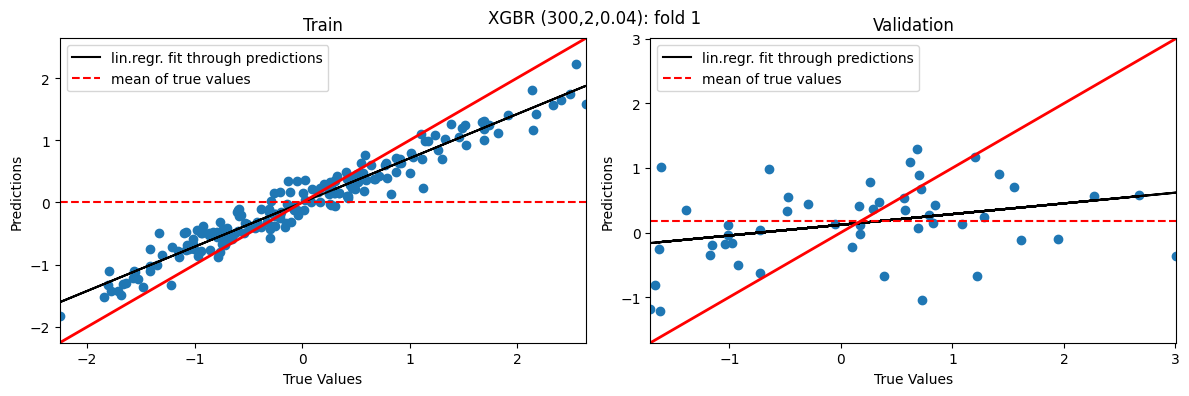

Train RMSE: 0.33882446393314025, MAE: 0.268923786805353
Validation RMSE: 1.122865382065362, MAE: 0.8636003563779957
------------------------------------------------------------------
------------------------------Fold 2------------------------------
------------------------------------------------------------------


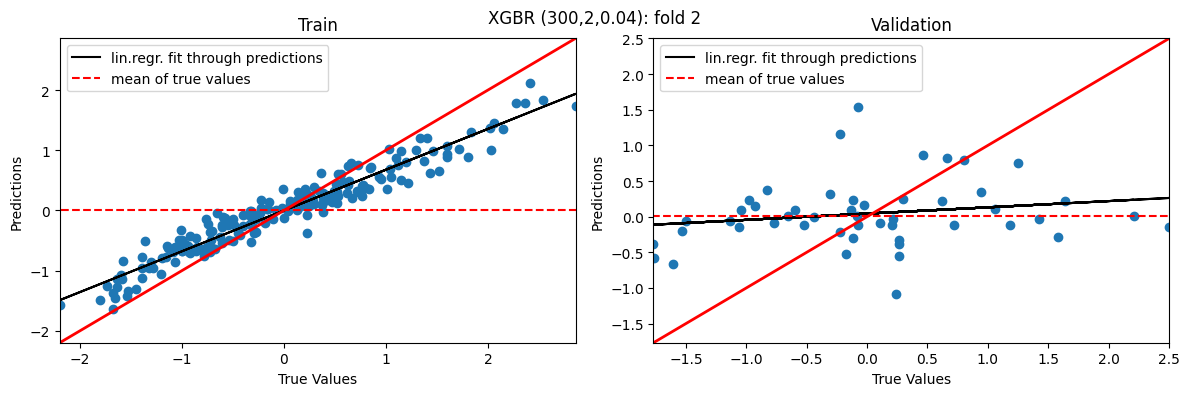

Train RMSE: 0.37221877896639205, MAE: 0.2997351614299328
Validation RMSE: 1.005274159548939, MAE: 0.8120594562298531
------------------------------------------------------------------
------------------------------Fold 3------------------------------
------------------------------------------------------------------


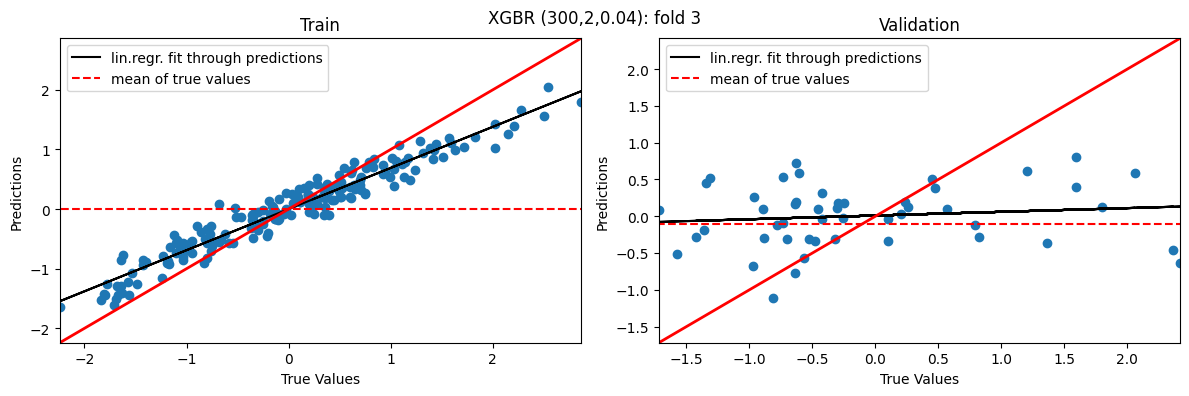

Train RMSE: 0.35787146413557064, MAE: 0.28337470209916454
Validation RMSE: 1.0663627498612678, MAE: 0.8155786613879239
------------------------------------------------------------------
------------------------------Fold 4------------------------------
------------------------------------------------------------------


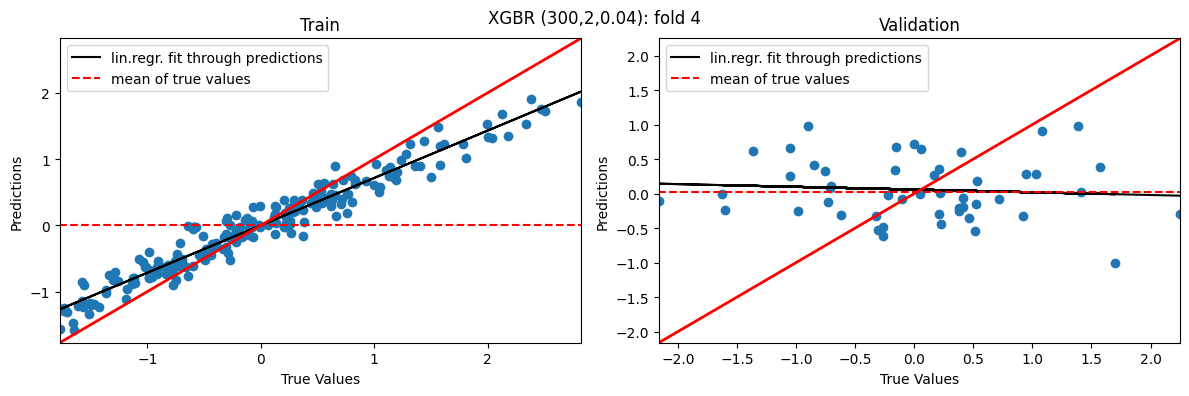

Train RMSE: 0.33431108221783107, MAE: 0.26417750737636403
Validation RMSE: 1.0401303541323783, MAE: 0.8199906366476362


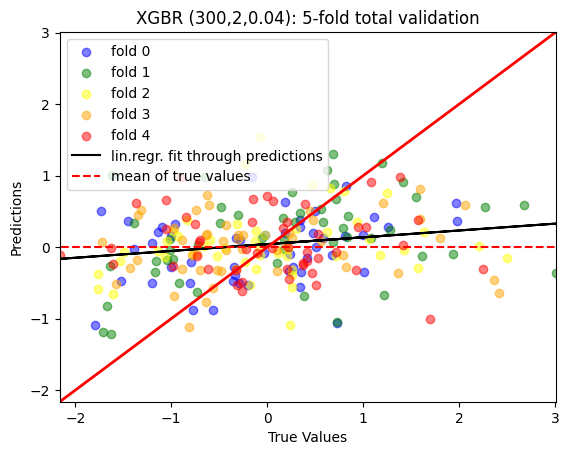

In [25]:
all_val_preds = []
all_val_true = []
for i,(train_idx,test_idx) in enumerate(kf.split(X)):
  print('-'*66)
  print('-'*30+f'Fold {i}'+'-'*30)
  print('-'*66)

  X_train = np.take(X, train_idx, axis=0)
  y_train = np.take(y, train_idx, axis=0)

  X_val = np.take(X, test_idx, axis=0)
  y_val = np.take(y, test_idx, axis=0)

  X_train,X_val = scale_fit_transform(X_train,X_val)
  y_train,y_val = scale_fit_transform(y_train,y_val)

  xgb_model = XGBRegressor(n_estimators=300, max_depth=2, learning_rate=0.04)
  xgb_model.fit(X_train,y_train)
  preds = xgb_model.predict(X_val)
  preds_train = xgb_model.predict(X_train)
  plot_predictions(y_val,preds,y_train,preds_train,f'XGBR (300,2,0.04): fold {i}')
  print(f'Train RMSE: {mean_squared_error(y_train,preds_train,squared=False)}, MAE: {mean_absolute_error(y_train,preds_train)}')
  print(f'Validation RMSE: {mean_squared_error(y_val,preds,squared=False)}, MAE: {mean_absolute_error(y_val,preds)}')

  all_val_preds.append(preds)
  all_val_true.append(y_val)
plot_all_validation(all_val_true,all_val_preds,'XGBR (300,2,0.04): 5-fold total validation')

In [26]:
print('Total validation RMSE:', mean_squared_error(np.concatenate(all_val_true).ravel(),np.concatenate(all_val_preds).ravel(),squared=False))
print('Total validation MAE:', mean_absolute_error(np.concatenate(all_val_true).ravel(),np.concatenate(all_val_preds).ravel()))

Total validation RMSE: 1.026790156411735
Total validation MAE: 0.8012488866651316


#RandomForestRegressor

## Hyperparameter tuning

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
rmse_dt = {}
for md in range(1,9,2):
  for e in range(10,200,30):
    all_rmses = []
    for i,(train_idx,test_idx) in enumerate(kf.split(X)):
      X_train = np.take(X, train_idx, axis=0)
      y_train = np.take(y, train_idx, axis=0)

      X_val = np.take(X, test_idx, axis=0)
      y_val = np.take(y, test_idx, axis=0)

      X_train,X_val = scale_fit_transform(X_train,X_val)
      y_train,y_val = scale_fit_transform(y_train,y_val)

      rf_m = RandomForestRegressor(max_depth=md,n_estimators=e)
      rf_m.fit(X_train,y_train.ravel())
      preds = rf_m.predict(X_val)
      rmse = mean_squared_error(y_val.ravel(),preds,squared=False)
      all_rmses.append(rmse)
    rmse_dt[(md,e)] = np.average(all_rmses)
    print(md,e,':',rmse_dt[(md,e)])

1 10 : 0.9871497903495294
1 40 : 0.9787628650701403
1 70 : 0.9782608543322031
1 100 : 0.9765848708942046
1 130 : 0.9808398167948956
1 160 : 0.9760897560756157
1 190 : 0.9803106363220351
3 10 : 0.9955537686002638
3 40 : 0.9800777714843475
3 70 : 0.9689937890033411
3 100 : 0.9761230664793553
3 130 : 0.9734191545031112
3 160 : 0.9853491728535679
3 190 : 0.9778126434470573
5 10 : 1.014420202123574
5 40 : 0.9871550410749309
5 70 : 0.9864572543638289
5 100 : 0.9932876850719987
5 130 : 0.9830118020715751
5 160 : 0.9820664050586873
5 190 : 0.975921096857703
7 10 : 1.0327465984185795
7 40 : 0.9792966180633403
7 70 : 0.9947302631706366
7 100 : 0.9865498632977902
7 130 : 0.9837436022094085
7 160 : 0.9819047884894803
7 190 : 0.9713180060765876


In [29]:
dict(sorted(rmse_dt.items(), key=lambda item: item[1]))

{(3, 70): 0.9689937890033411,
 (7, 190): 0.9713180060765876,
 (3, 130): 0.9734191545031112,
 (5, 190): 0.975921096857703,
 (1, 160): 0.9760897560756157,
 (3, 100): 0.9761230664793553,
 (1, 100): 0.9765848708942046,
 (3, 190): 0.9778126434470573,
 (1, 70): 0.9782608543322031,
 (1, 40): 0.9787628650701403,
 (7, 40): 0.9792966180633403,
 (3, 40): 0.9800777714843475,
 (1, 190): 0.9803106363220351,
 (1, 130): 0.9808398167948956,
 (7, 160): 0.9819047884894803,
 (5, 160): 0.9820664050586873,
 (5, 130): 0.9830118020715751,
 (7, 130): 0.9837436022094085,
 (3, 160): 0.9853491728535679,
 (5, 70): 0.9864572543638289,
 (7, 100): 0.9865498632977902,
 (1, 10): 0.9871497903495294,
 (5, 40): 0.9871550410749309,
 (5, 100): 0.9932876850719987,
 (7, 70): 0.9947302631706366,
 (3, 10): 0.9955537686002638,
 (5, 10): 1.014420202123574,
 (7, 10): 1.0327465984185795}

## Best/worst models

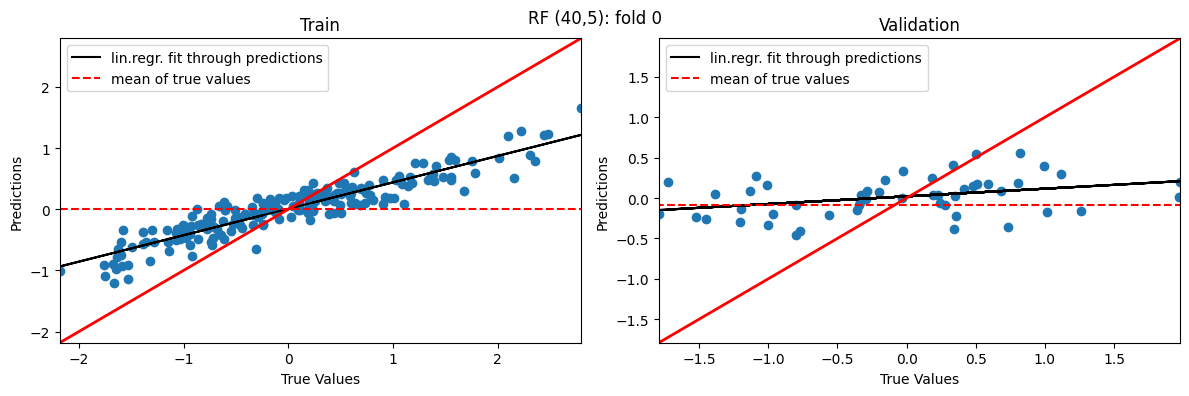

Train RMSE: 0.5960149846803934, MAE: 0.4878854026986641
Validation RMSE: 0.8489167942448655, MAE: 0.6741351522507825


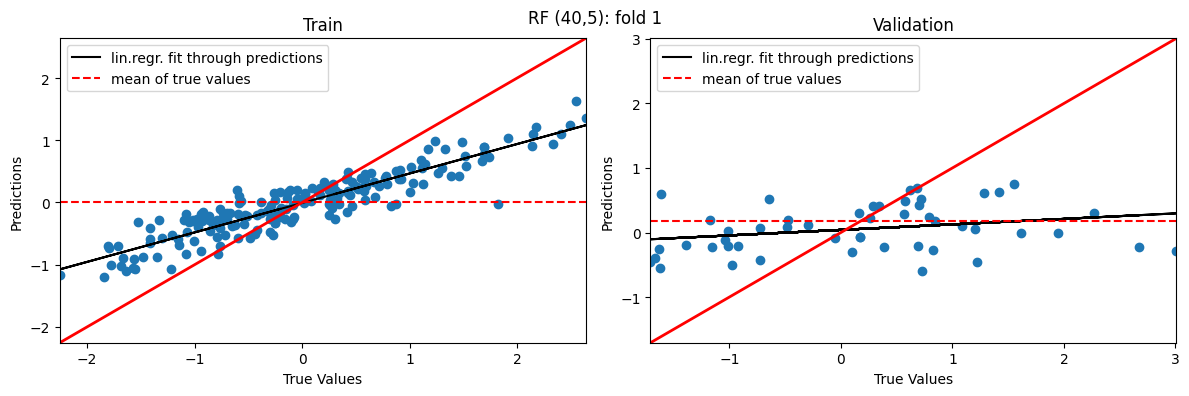

Train RMSE: 0.5643473815232198, MAE: 0.4483446024696597
Validation RMSE: 1.1264866254169164, MAE: 0.8749377646330196


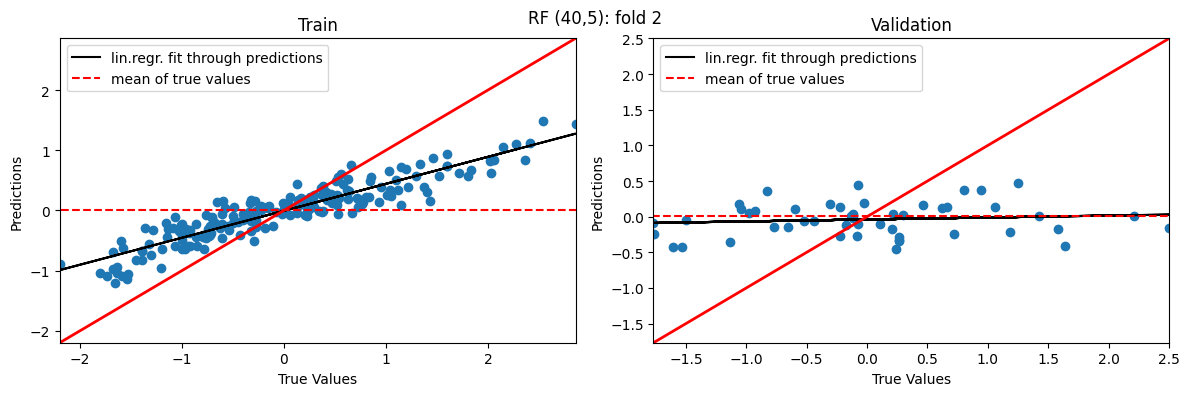

Train RMSE: 0.5840160223293462, MAE: 0.4740742885976495
Validation RMSE: 0.9859246642196979, MAE: 0.7817691083496862


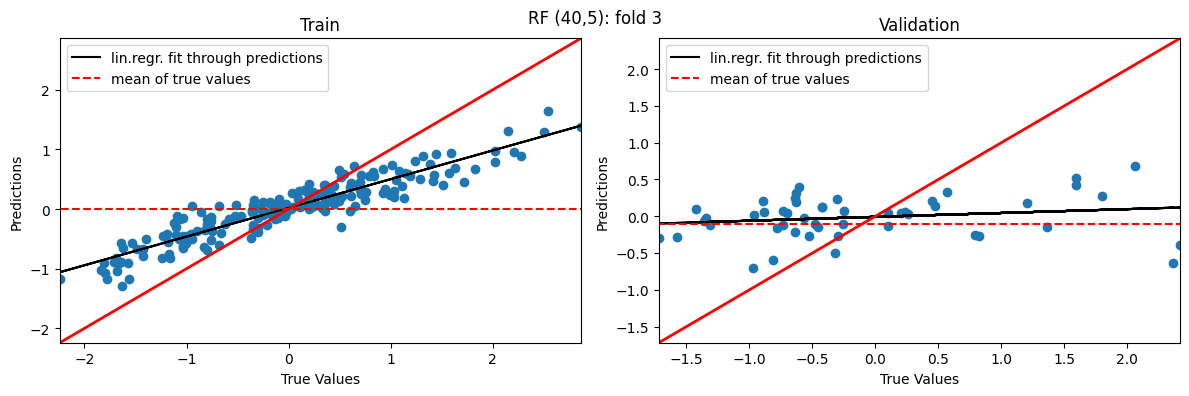

Train RMSE: 0.5517072340962837, MAE: 0.4400143004954128
Validation RMSE: 1.0191117376315253, MAE: 0.8070027562044055


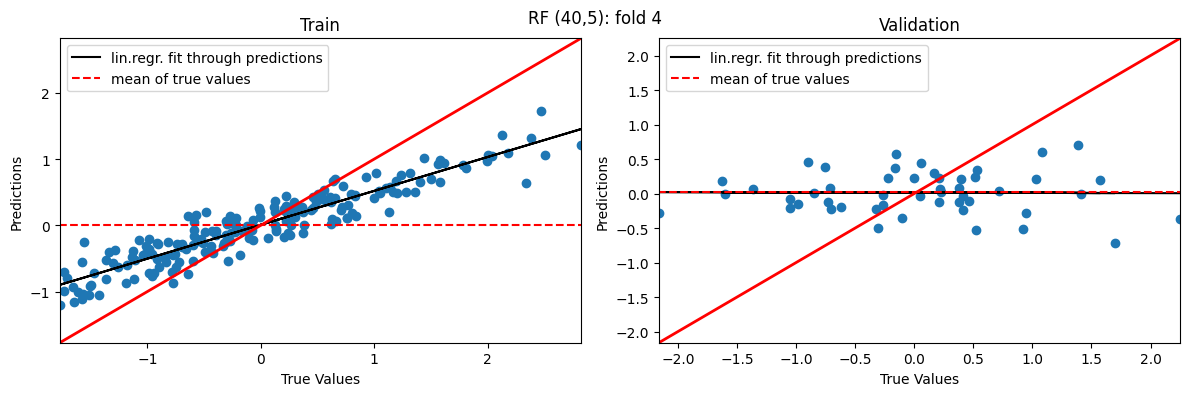

Train RMSE: 0.5268477073042708, MAE: 0.4210240429199698
Validation RMSE: 0.9592045176584547, MAE: 0.743609945495515


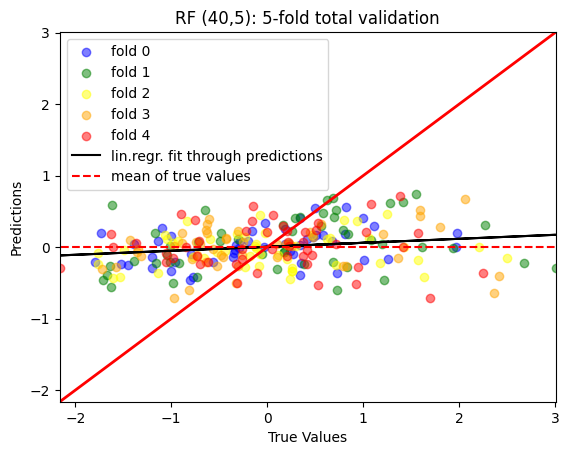

In [30]:
all_val_preds = []
all_val_true = []
for i,(train_idx,test_idx) in enumerate(kf.split(X)):
  X_train = np.take(X, train_idx, axis=0)
  y_train = np.take(y, train_idx, axis=0)

  X_val = np.take(X, test_idx, axis=0)
  y_val = np.take(y, test_idx, axis=0)

  X_train,X_val = scale_fit_transform(X_train,X_val)
  y_train,y_val = scale_fit_transform(y_train,y_val)

  rf_m = RandomForestRegressor(max_depth=5,n_estimators=40)
  rf_m.fit(X_train,y_train.ravel())

  preds = rf_m.predict(X_val)
  preds_train = rf_m.predict(X_train)
  plot_predictions(y_val,preds,y_train,preds_train,f'RF (40,5): fold {i}')
  print(f'Train RMSE: {mean_squared_error(y_train,preds_train,squared=False)}, MAE: {mean_absolute_error(y_train,preds_train)}')
  print(f'Validation RMSE: {mean_squared_error(y_val,preds,squared=False)}, MAE: {mean_absolute_error(y_val,preds)}')

  all_val_preds.append(preds)
  all_val_true.append(y_val)
plot_all_validation(all_val_true,all_val_preds,'RF (40,5): 5-fold total validation')

In [31]:
print('Total validation RMSE:', mean_squared_error(np.concatenate(all_val_true).ravel(),np.concatenate(all_val_preds).ravel(),squared=False))
print('Total validation MAE:', mean_absolute_error(np.concatenate(all_val_true).ravel(),np.concatenate(all_val_preds).ravel()))

Total validation RMSE: 0.9920460122934053
Total validation MAE: 0.7762767390146592


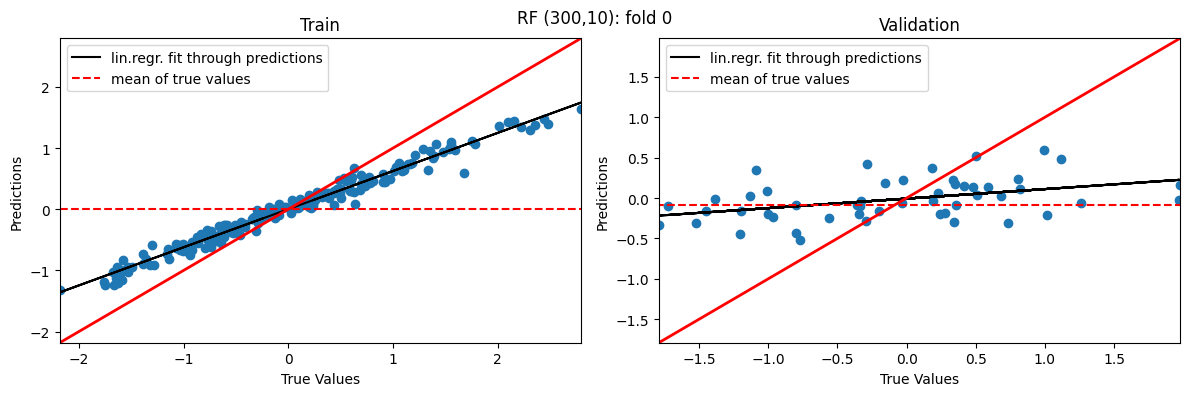

Train RMSE: 0.3887548544944149, MAE: 0.3102239876215928
Validation RMSE: 0.8273387729398172, MAE: 0.6549935746585382


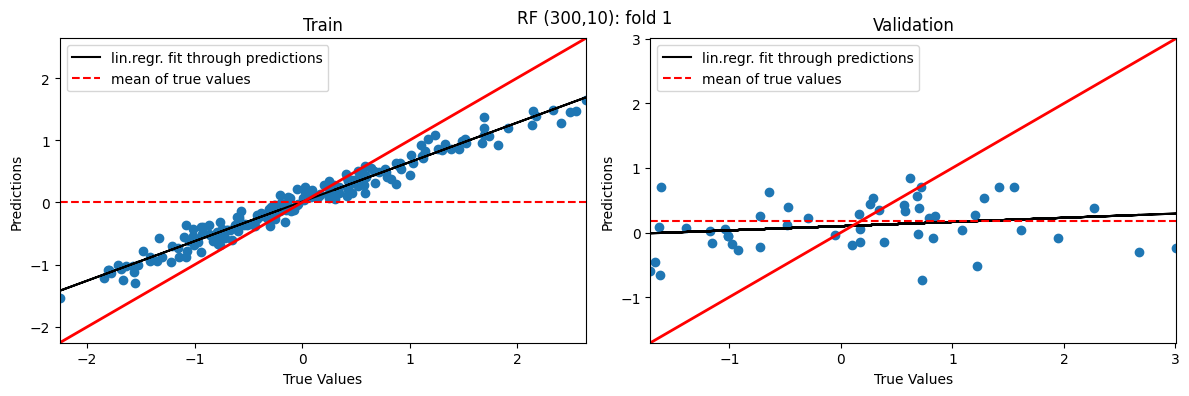

Train RMSE: 0.383158155879451, MAE: 0.30048337744578485
Validation RMSE: 1.1507206519202522, MAE: 0.9015756642551535


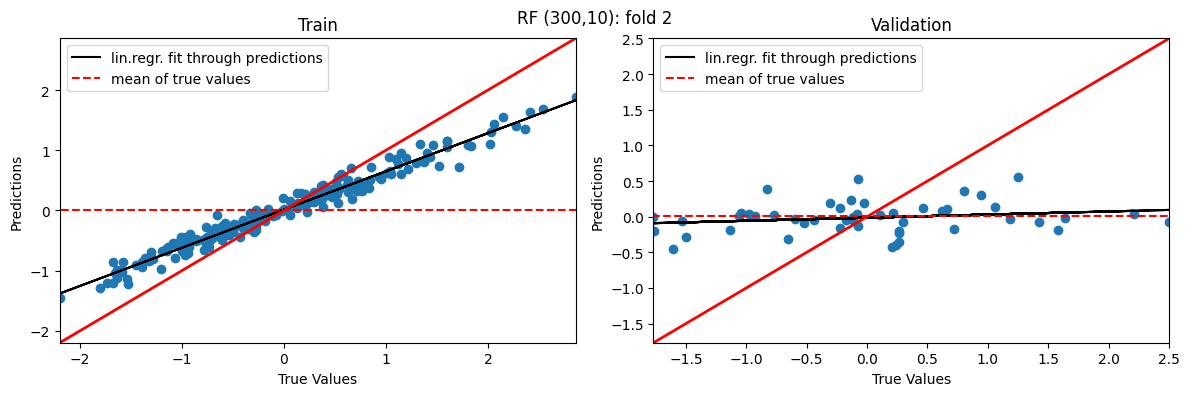

Train RMSE: 0.3831559851181623, MAE: 0.30767702253912244
Validation RMSE: 0.9654469726759074, MAE: 0.7729093358405184


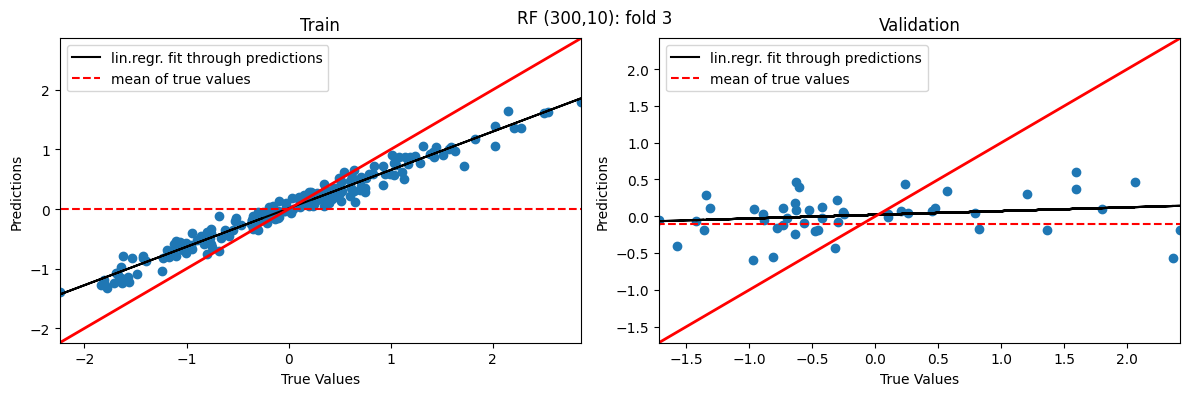

Train RMSE: 0.37466070261337336, MAE: 0.2972034116697985
Validation RMSE: 1.0177806013715682, MAE: 0.8103981604571332


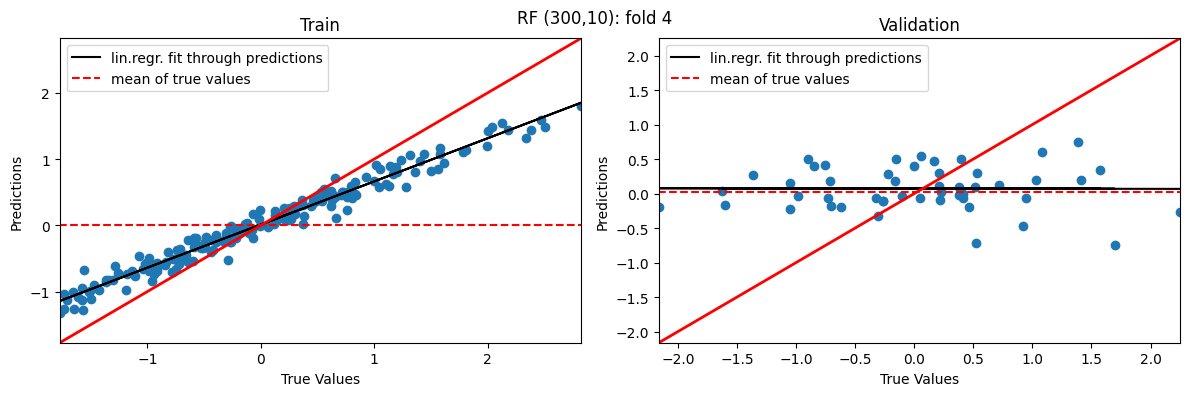

Train RMSE: 0.36754061491374485, MAE: 0.28914126043012706
Validation RMSE: 0.9618639438181522, MAE: 0.7497675392985345


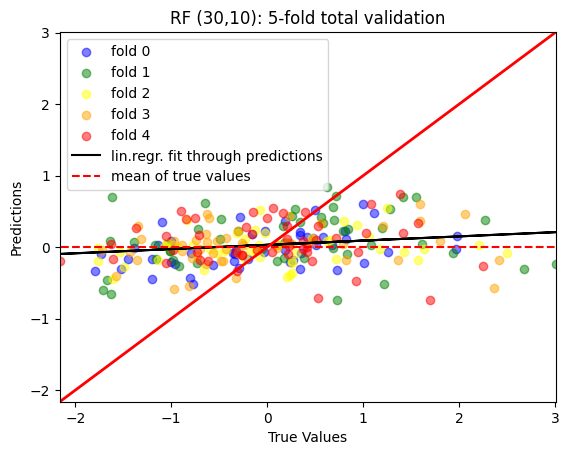

In [32]:
all_val_preds = []
all_val_true = []
for i,(train_idx,test_idx) in enumerate(kf.split(X)):
    X_train = np.take(X, train_idx, axis=0)
    y_train = np.take(y, train_idx, axis=0)

    X_val = np.take(X, test_idx, axis=0)
    y_val = np.take(y, test_idx, axis=0)

    X_train,X_val = scale_fit_transform(X_train,X_val)
    y_train,y_val = scale_fit_transform(y_train,y_val)

    rf_m = RandomForestRegressor(max_depth=10,n_estimators=300)
    rf_m.fit(X_train,y_train.ravel())

    preds = rf_m.predict(X_val)
    preds_train = rf_m.predict(X_train)
    plot_predictions(y_val,preds,y_train,preds_train,f'RF (300,10): fold {i}')
    print(f'Train RMSE: {mean_squared_error(y_train,preds_train,squared=False)}, MAE: {mean_absolute_error(y_train,preds_train)}')
    print(f'Validation RMSE: {mean_squared_error(y_val,preds,squared=False)}, MAE: {mean_absolute_error(y_val,preds)}')

    all_val_preds.append(preds)
    all_val_true.append(y_val)

plot_all_validation(all_val_true,all_val_preds,'RF (30,10): 5-fold total validation')

In [33]:
print('Total validation RMSE:', mean_squared_error(np.concatenate(all_val_true).ravel(),np.concatenate(all_val_preds).ravel(),squared=False))
print('Total validation MAE:', mean_absolute_error(np.concatenate(all_val_true).ravel(),np.concatenate(all_val_preds).ravel()))

Total validation RMSE: 0.9902287768664633
Total validation MAE: 0.7779317355866304
